In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
import joblib
from sklearn import tree


from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.preprocessing import label_binarize
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

# Read data


In [10]:
PATH = "E:\Folder tai lieu\Lectures\Prethesis\Data\Student_performance_data_kaggle.csv"    
df = pd.read_csv(PATH)
OUT_DIR = Path("prethesis_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42

# Normalize column name


In [11]:
df.columns = [c.strip().replace(" ", "_") for c in df.columns]
df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


# Data preprocessing


In [ ]:
def df_overview(df, name="DataFrame"):
    print(f"== {name} OVERVIEW ==")
    print("Shape (rows, cols):", df.shape)
    print("\nDtypes:")
    print(df.dtypes)
    print("\nSample:")
    print(df.head(3))
    print("-" * 40)

def missing_report(df, name="DataFrame"):
    miss_cnt = df.isna().sum()
    miss_pct = (df.isna().mean() * 100).round(2)
    rep = pd.DataFrame({"missing_count": miss_cnt, "missing_pct": miss_pct})
    rep_sorted = rep[rep.missing_count > 0].sort_values("missing_pct", ascending=False)
    print(f"== {name} MISSING REPORT ==")
    if rep_sorted.empty:
        print("No missing values detected.")
    else:
        display(rep_sorted)
    print("-" * 40)

def class_ratio(df, label_col, name="DataFrame"):
    print(f"== {name} CLASS RATIO on '{label_col}' ==")
    counts = df[label_col].value_counts(dropna=False)
    ratio = (counts / counts.sum() * 100).round(2)
    rep = pd.DataFrame({"count": counts, "ratio_%": ratio})
    display(rep)
    
    #Imbalance
    if ratio.max() > 60:
        print("Dataset shows signs of imbalance (one class > 60%).")
    else:
        print("Class distribution is relatively balanced.")
    print("-" * 40)
    
    df_overview(df, name="Kaggle")
missing_report(df, name="Kaggle")

# Drop StudentID
if "StudentID" in df.columns:
    df = df.drop(columns=["StudentID"])

# Target
target_col = "GradeClass"
df[target_col] = df[target_col].astype(int)

# Feature / target
X = df.drop(columns=[target_col])
y = df[target_col]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Preprocessing numeric (impute median)
numeric_features = X.columns.tolist()
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features)],
    remainder="drop"
)
print("Preprocessing pipeline ready")


== Kaggle MISSING REPORT ==
No missing values detected.
----------------------------------------
Preprocessing pipeline ready


# GPA

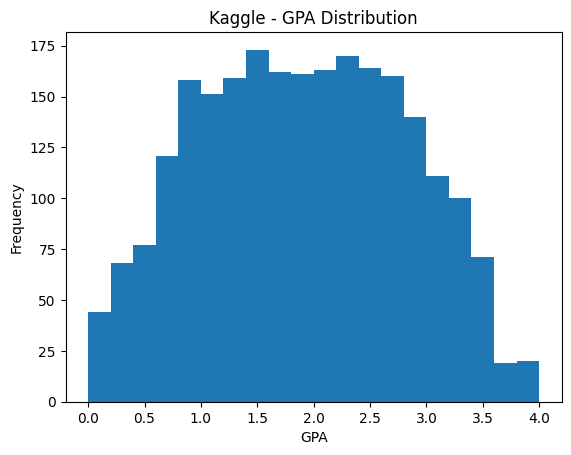

== Kaggle CLASS RATIO on 'GradeClass' ==


,count,ratio_%
GradeClass,,
4,1211,50.63
3,414,17.31
2,391,16.35
1,269,11.25
0,107,4.47


Class distribution is relatively balanced.
----------------------------------------
== Kaggle OVERVIEW ==
Shape (rows, cols): (2392, 14)

Dtypes:
Age                    int64
Gender                 int64
Ethnicity              int64
ParentalEducation      int64
StudyTimeWeekly      float64
Absences               int64
Tutoring               int64
ParentalSupport        int64
Extracurricular        int64
Sports                 int64
Music                  int64
Volunteering           int64
GPA                  float64
GradeClass             int64
dtype: object

Sample:
   Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  Absences  \
0   17       1          0                  2        19.833723         7   
1   18       0          0                  1        15.408756         0   
2   15       0          2                  3         4.210570        26   

   Tutoring  ParentalSupport  Extracurricular  Sports  Music  Volunteering  \
0         1                2                0 

In [ ]:
assert "GPA" in df.columns
plt.figure()
df["GPA"].dropna().plot(kind="hist", bins=20)
plt.title("Kaggle - GPA Distribution")
plt.xlabel("GPA")
plt.ylabel("Frequency")
plt.show()

assert "GradeClass" in df.columns
class_ratio(df, label_col="GradeClass", name="Kaggle")
plt.show()

# Model Building


Fitting 3 folds for each of 20 candidates, totalling 60 fits
>>> Best params: {'model__ccp_alpha': np.float64(0.003745401188473625), 'model__criterion': 'gini', 'model__max_depth': 13, 'model__min_samples_leaf': 8, 'model__min_samples_split': 22}
>>> Metrics: {
  "accuracy": 0.9248434237995825,
  "precision_weighted": 0.9261858189687269,
  "recall_weighted": 0.9248434237995825,
  "f1_weighted": 0.9220626500366778,
  "precision_macro": 0.9302091866314026,
  "recall_macro": 0.8448352084228924,
  "f1_macro": 0.8725091447699823,
  "roc_auc_ovr_weighted": 0.9453717941108472
}

>>> Classification report:
               precision    recall  f1-score   support

           0     1.0000    0.5238    0.6875        21
           1     0.9057    0.8889    0.8972        54
           2     0.9136    0.9487    0.9308        78
           3     0.8916    0.8916    0.8916        83
           4     0.9402    0.9712    0.9555       243

    accuracy                         0.9248       479
   macro avg 

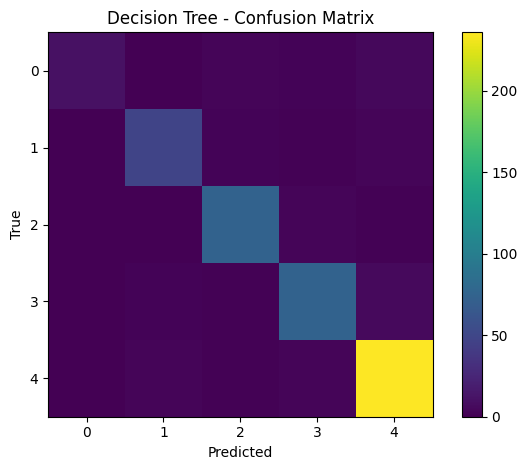

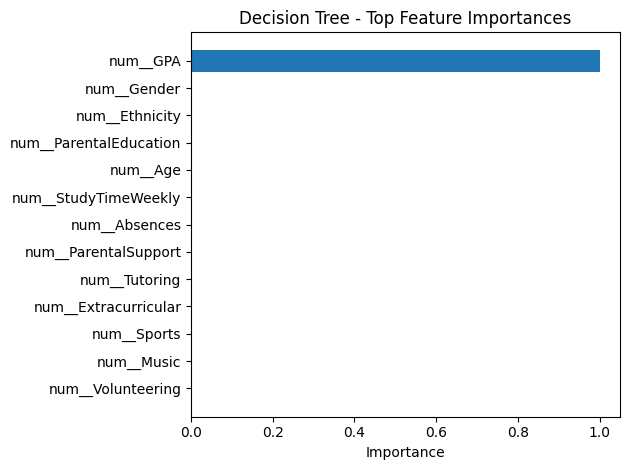


>>> 10-Fold CV results (mean ± std):
accuracy       : 0.9298 ± 0.0138
precision_macro: 0.9271 ± 0.0225
recall_macro   : 0.8641 ± 0.0356
f1_macro       : 0.8886 ± 0.0314
f1_weighted    : 0.9275 ± 0.0151


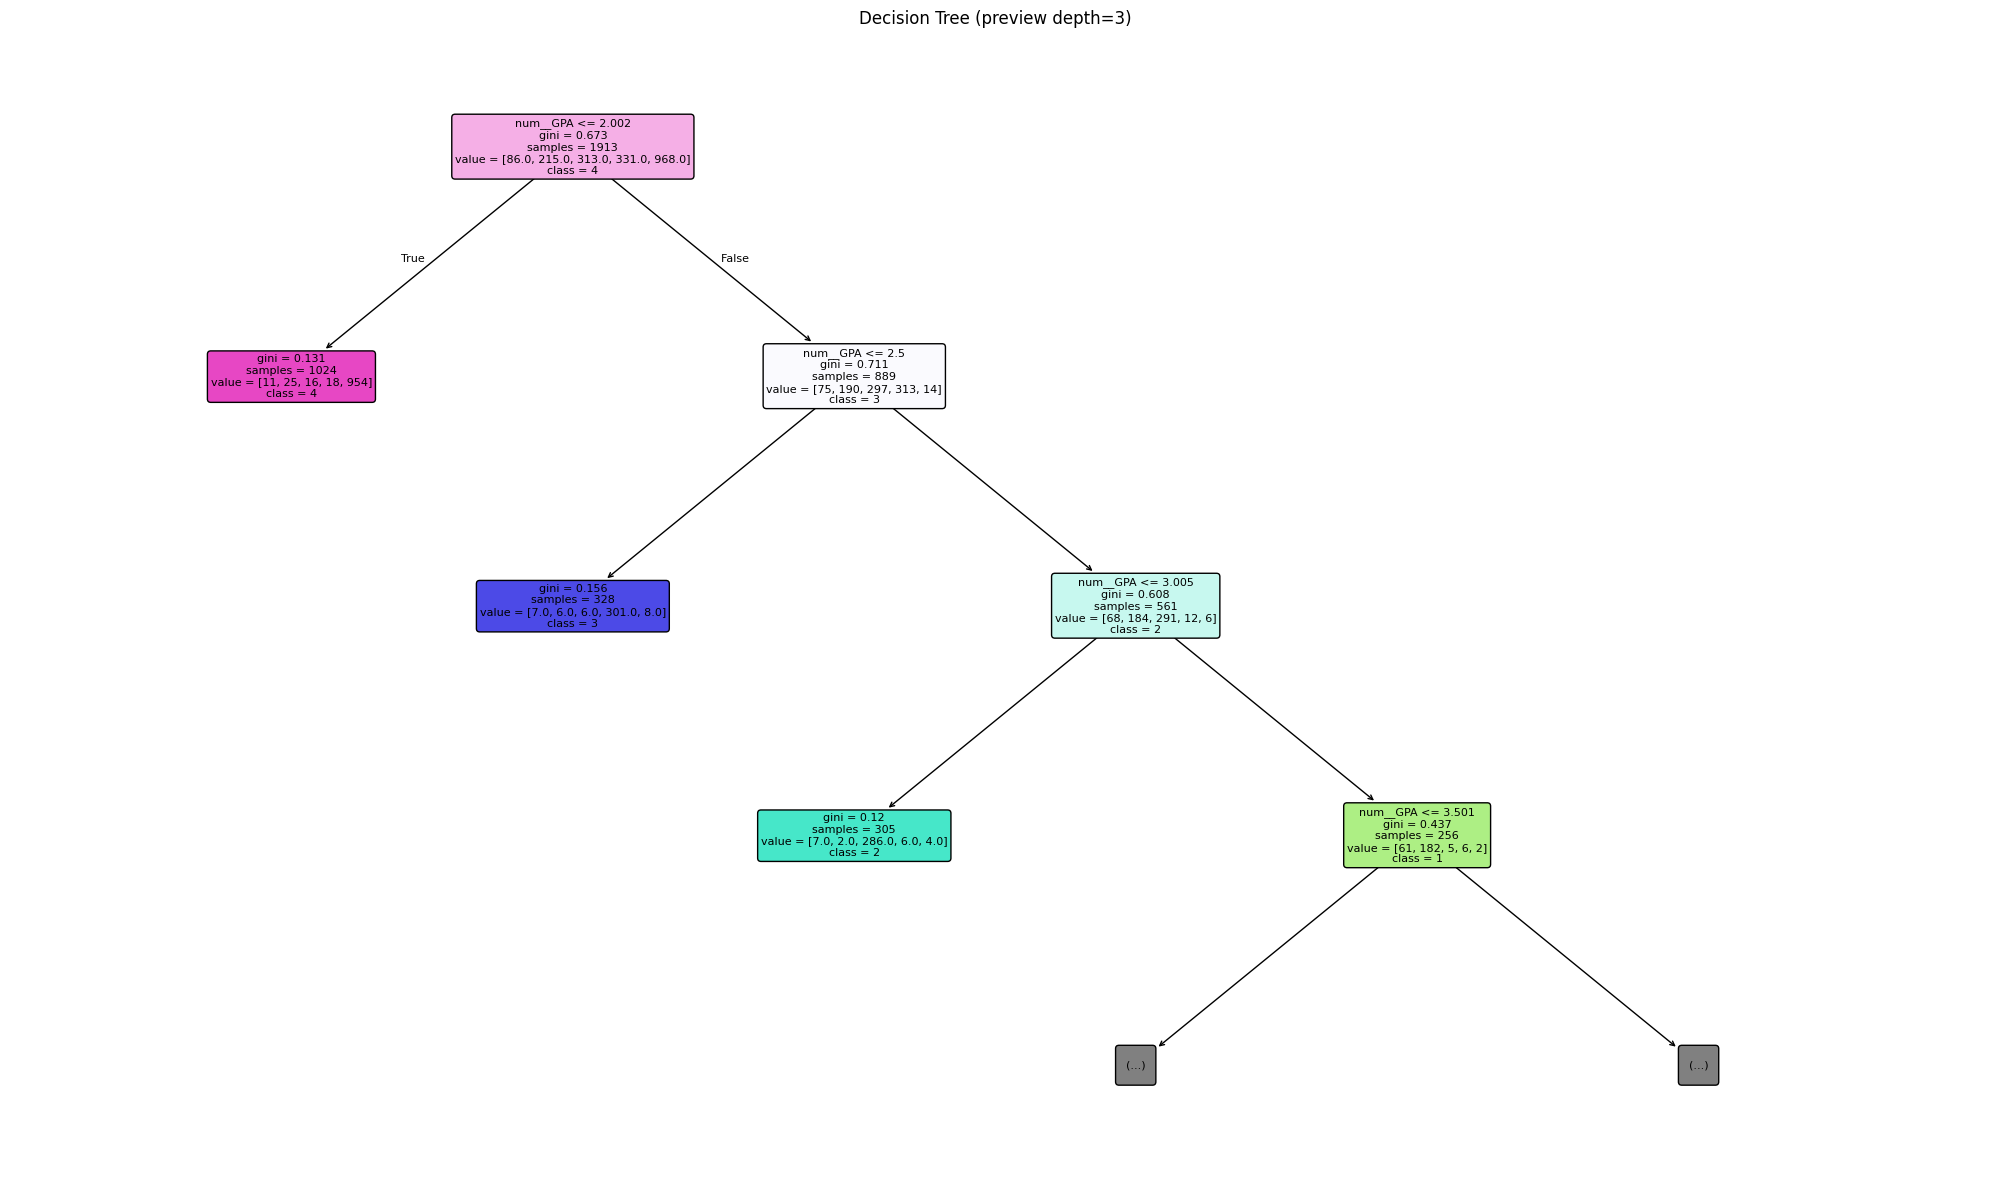


Artifacts saved in: E:\Folder tai lieu\Lectures\Prethesis\prethesis_outputs


In [ ]:
# Pipeline
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(random_state=RANDOM_STATE))
])
#  RandomizedSearch 
param_distributions = {
    "model__criterion": ["gini", "entropy", "log_loss"],
    "model__max_depth": randint(3, 16),
    "model__min_samples_split": randint(2, 51),
    "model__min_samples_leaf": randint(1, 21),
    "model__ccp_alpha": uniform(0.0, 0.01),
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=20,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

#  Train 
search.fit(X_train, y_train)
best_clf = search.best_estimator_
best_params = search.best_params_
print(">>> Best params:", best_params)

#  Predict & Metrics 
y_pred = best_clf.predict(X_test)

metrics = {
    "accuracy": float(accuracy_score(y_test, y_pred)),
    "precision_weighted": float(precision_score(y_test, y_pred, average="weighted", zero_division=0)),
    "recall_weighted": float(recall_score(y_test, y_pred, average="weighted", zero_division=0)),
    "f1_weighted": float(f1_score(y_test, y_pred, average="weighted", zero_division=0)),
    "precision_macro": float(precision_score(y_test, y_pred, average="macro", zero_division=0)),
    "recall_macro": float(recall_score(y_test, y_pred, average="macro", zero_division=0)),
    "f1_macro": float(f1_score(y_test, y_pred, average="macro", zero_division=0)),
}

# ROC-AUC OvR (multi-class)
try:
    y_proba = best_clf.predict_proba(X_test)
    classes = np.unique(y)
    y_test_bin = label_binarize(y_test, classes=classes)
    metrics["roc_auc_ovr_weighted"] = float(
        roc_auc_score(y_test_bin, y_proba, multi_class="ovr", average="weighted")
    )
except Exception:
    metrics["roc_auc_ovr_weighted"] = None

print(">>> Metrics:", json.dumps(metrics, indent=2))

#  Classification report & Confusion matrix 
report_txt = classification_report(y_test, y_pred, digits=4)
print("\n>>> Classification report:\n", report_txt)

cm = confusion_matrix(y_test, y_pred, labels=np.sort(np.unique(y)))
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{c}" for c in np.sort(np.unique(y))],
    columns=[f"pred_{c}" for c in np.sort(np.unique(y))]
)

#  Feature names setup  
try:
    pre = best_clf.named_steps["preprocess"]
    if hasattr(pre, "get_feature_names_out"):
        feature_cols = pre.get_feature_names_out()
    else:
        feature_cols = np.array(X.columns, dtype=str)
except Exception:
    feature_cols = np.array(X.columns, dtype=str)
tree_model = best_clf.named_steps["model"]
n_model_in = getattr(tree_model, "n_features_in_", None)
if n_model_in is not None and len(feature_cols) != n_model_in:
    feature_cols = np.array([f"feature_{i}" for i in range(n_model_in)], dtype=str)

#  Feature importance 
importances = pd.DataFrame({
    "feature": feature_cols,
    "importance": tree_model.feature_importances_
}).sort_values("importance", ascending=False)

#  Save artifacts 
with open(OUT_DIR / "dt_best_params.json", "w", encoding="utf-8") as f:
    json.dump(best_params, f, ensure_ascii=False, indent=2)

with open(OUT_DIR / "dt_metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

with open(OUT_DIR / "dt_classification_report.txt", "w", encoding="utf-8") as f:
    f.write(report_txt)

cm_df.to_csv(OUT_DIR / "dt_confusion_matrix.csv", index=True)
importances.to_csv(OUT_DIR / "dt_feature_importances.csv", index=False)
joblib.dump(best_clf, OUT_DIR / "dt_best_model.joblib")

#  Plots 
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Decision Tree - Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(np.sort(np.unique(y))))
plt.xticks(tick_marks, np.sort(np.unique(y)))
plt.yticks(tick_marks, np.sort(np.unique(y)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(OUT_DIR / "dt_confusion_matrix.png", dpi=130)
plt.show()

top_k = min(15, len(importances))
plt.figure()
imp_slice = importances.head(top_k).iloc[::-1]
plt.barh(imp_slice["feature"], imp_slice["importance"])
plt.title("Decision Tree - Top Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(OUT_DIR / "dt_feature_importances.png", dpi=130)
plt.show()

#  (A) 10-fold Stratified Cross-Validation 
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision_macro": make_scorer(precision_score, average="macro", zero_division=0),
    "recall_macro": make_scorer(recall_score, average="macro", zero_division=0),
    "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
    "f1_weighted": make_scorer(f1_score, average="weighted", zero_division=0),
}

cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

cv_results = cross_validate(
    estimator=best_clf,  # pipeline đã tối ưu thông qua RandomizedSearchCV
    X=X, y=y,
    cv=cv10,
    scoring=scoring,
    return_train_score=False
)

cv_table = pd.DataFrame({
    "accuracy":        cv_results["test_accuracy"],
    "precision_macro": cv_results["test_precision_macro"],
    "recall_macro":    cv_results["test_recall_macro"],
    "f1_macro":        cv_results["test_f1_macro"],
    "f1_weighted":     cv_results["test_f1_weighted"],
})
cv_table.to_csv(OUT_DIR / "dt_cv10_scores.csv", index=False)

print("\n>>> 10-Fold CV results (mean ± std):")
for metric in ["accuracy", "precision_macro", "recall_macro", "f1_macro", "f1_weighted"]:
    scores = cv_table[metric].values
    print(f"{metric:15s}: {scores.mean():.4f} ± {scores.std():.4f}")

#  (B) Lưu dự đoán test (y_true, y_pred, proba từng lớp) 
preds_df = pd.DataFrame({"y_true": y_test, "y_pred": y_pred})

try:
    y_proba = best_clf.predict_proba(X_test)
    classes_sorted = np.sort(np.unique(y))
    for i, cls in enumerate(classes_sorted):
        preds_df[f"proba_{cls}"] = y_proba[:, i]
except Exception:
    pass

preds_df.to_csv(OUT_DIR / "dt_test_predictions.csv", index=False)

#  (C) Export tree (preview rút gọn) 
plt.figure(figsize=(20, 12))
class_names = [str(c) for c in np.sort(np.unique(y))]
tree.plot_tree(
    best_clf.named_steps["model"],
    feature_names=feature_cols,
    class_names=class_names,
    filled=True,
    max_depth=3,  
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree (preview depth=3)")
plt.tight_layout()
plt.savefig(OUT_DIR / "dt_tree_preview_depth3.png", dpi=150)
plt.show()

# (D) Model Card (JSON) tổng hợp 
model_card = {
    "model_type": "DecisionTreeClassifier",
    "best_params": best_params,
    "test_metrics": metrics,
    "cv10_mean": {m: float(cv_table[m].mean()) for m in cv_table.columns},
    "cv10_std":  {m: float(cv_table[m].std())  for m in cv_table.columns},
    "n_features": int(len(feature_cols)),
    "features": [str(f) for f in feature_cols],
    "artifacts": {
        "best_params": str(OUT_DIR / "dt_best_params.json"),
        "metrics": str(OUT_DIR / "dt_metrics.json"),
        "classification_report": str(OUT_DIR / "dt_classification_report.txt"),
        "confusion_matrix_csv": str(OUT_DIR / "dt_confusion_matrix.csv"),
        "feature_importances_csv": str(OUT_DIR / "dt_feature_importances.csv"),
        "cv10_scores_csv": str(OUT_DIR / "dt_cv10_scores.csv"),
        "test_predictions_csv": str(OUT_DIR / "dt_test_predictions.csv"),
        "tree_preview_png": str(OUT_DIR / "dt_tree_preview_depth3.png"),
        "model_joblib": str(OUT_DIR / "dt_best_model.joblib"),
    },
    "notes": [
        "Preprocess: SimpleImputer(strategy='median') cho toàn bộ numeric features.",
        "RandomizedSearchCV tối ưu theo f1_weighted; pipeline đã đóng gói preprocessing.",
        "CV: StratifiedKFold(n_splits=10, shuffle=True) để đánh giá ổn định hơn."
    ]
}

with open(OUT_DIR / "dt_model_card.json", "w", encoding="utf-8") as f:
    json.dump(model_card, f, ensure_ascii=False, indent=2)

print("\nArtifacts saved in:", OUT_DIR.resolve())
